## Categorical Feature Encoding Challenge
- Feature 정리
    - train 30만 개 중 target은 0이 21만개, 1이 9만개 정도. baseline은 0.7
    - 모든 변수는 범주형인데, 그 중 unique한 값이 가장 많은 nom_9는 11981개
    - ord_3는 알파벳 소문자 26개 중 15개 (a ~ o). m이 아주 적음
    - ord_4는 알파벳 대문자 26개. 역시 M이 아주 적음
    - day는 0~7. 6이 아주 적음
    - month는 1~12. 역시 6이 아주 적음
    - ord_5는 1,2번째 글자로 나뉨. 대소문자 알파벳이며 첫째 문자(ord_5a)는 모든 대소문자가 있고(52개), 두번째 문자(ord_5b)는 소문자 z만 빠진 51개
- 모델 학습하고 나서 _coef로 feature importance 보기!!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks') # 그래프를 seaborn 스타일로 그리기
plt.rc('font', family = 'Malgun Gothic') # 한글 처리

from sklearn.linear_model import LogisticRegression
import scipy
from tqdm import tqdm_notebook as tqdm

In [2]:
%%time
train = pd.read_csv("../input/cat-in-the-dat/train.csv")
test = pd.read_csv("../input/cat-in-the-dat/test.csv")

print(train.shape)
print(test.shape)

(300000, 25)
(200000, 24)
CPU times: user 2.26 s, sys: 246 ms, total: 2.51 s
Wall time: 3.43 s


In [3]:
print(train.columns)
train.head()
#ord_5를 두개의 컬럼으로 나누기!!!
#ord_2를 온도로 매핑하기?? 일반적인 차가운 온도 or 1,2,3,4,5 같이 순서 있게

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,T,Y,Green,Triangle,Snake,Finland,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [9]:
train.columns

Index(['id', 'bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1',
       'nom_2', 'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
       'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month',
       'target'],
      dtype='object')

- ord_3는 알파벳 소문자 26개 중 15개 (a ~ o). m이 아주 적음
- ord_4는 알파벳 대문자 26개. 역시 M이 아주 적음
- day는 0~7. 6이 아주 적음
- month는 1~12. 역시 6이 아주 적음
- ord_5는 1,2번째 글자로 나뉨. 대소문자 알파벳이며 첫째 문자(ord_5a)는 모든 대소문자가 있고(52개), 두번째 문자(ord_5b)는 소문자 z만 빠진 51개
    - 생각해 보니 z만 빠진 거 가지고 뭘 생성할 수 있나??

In [12]:
for col in ['ord_3', 'ord_4']:
    print(test[col].unique().shape)

(15,)
(26,)


In [31]:
# 데이터 합쳐서 Feature Engineering
ddall = train.append(test, sort = False)
num_train = len(train)
print(ddall.shape)

(500000, 25)


In [32]:
ddall['ord_5a'] = ddall['ord_5'].str[0]
ddall['ord_5b'] = ddall['ord_5'].str[1]

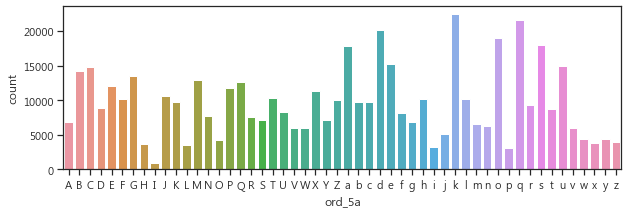

In [33]:
# 그래프 그리기 -> ord_5 a,b는 딱히 분포의 편차가 보이진 않음.
plt.figure(figsize = (10, 3))
sns.countplot(ddall['ord_5a'].sort_values())

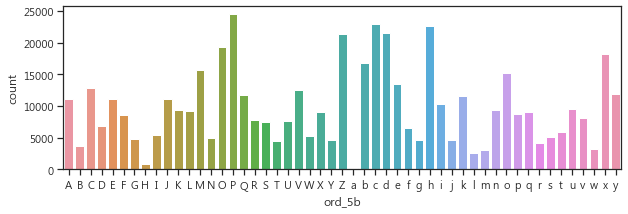

In [34]:
plt.figure(figsize = (10, 3))
sns.countplot(ddall['ord_5b'].sort_values())

In [35]:
ddall.shape

(500000, 27)

In [36]:
# 드랍할 칼럼 목록
drop_cols = ['ord_5']

In [37]:
# train, test 모두에 들어있지 않는 값을 single value('xor')로 변경
# 근데 왜 이 칼럼만 해당하지??
for col in ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']:
    train_vals = set(train[col].unique())
    test_vals = set(test[col].unique())
    
    # ^ 연산 -> XOR(같으면 0, 다르면 1). 교집합 제외한 나머지가 남음
    xor_cat_vals = train_vals ^ test_vals
    print(col, "XOR 값 수:", len(xor_cat_vals))
    if xor_cat_vals: # 값이 있으면 loop 안으로 들어감. 참고해 두기!!
        ddall.loc[ddall[col].isin(xor_cat_vals), col] = 'xor'

nom_5 XOR 값 수: 0
nom_6 XOR 값 수: 0
nom_7 XOR 값 수: 1
nom_8 XOR 값 수: 9
nom_9 XOR 값 수: 316


In [54]:
%%time
# One-Hot Encoding
X = ddall[ddall.columns.difference(['id', 'target'] + drop_cols)] #해당 칼럼들을 뺀 것.
# 아래 6개 칼럼은 원핫 안함. 왜 이것들만??
X_oh = X[X.columns.difference(['ord_1', 'ord_4', 'ord_5a', 'ord_5b', 'day', 'month'])]
oh1 = pd.get_dummies(X_oh, columns = X_oh.columns, drop_first=True, sparse=True) #이거 sparse 안하면 실행시간 오래 걸림.
# 값 개수가 많은 nom_9도 원핫??

CPU times: user 14.9 s, sys: 991 ms, total: 15.8 s
Wall time: 13 s


In [56]:
print(type(oh1)) # SparseDataFrame
print(oh1.shape)
print(oh1.columns[:10])

<class 'pandas.core.sparse.frame.SparseDataFrame'>
(500000, 15969)
Index(['bin_0_1', 'bin_1_1', 'bin_2_1', 'bin_3_T', 'bin_4_Y', 'nom_0_Green',
       'nom_0_Red', 'nom_1_Polygon', 'nom_1_Square', 'nom_1_Star'],
      dtype='object')


### Thermometer Encoder

In [40]:
from sklearn.base import TransformerMixin
from itertools import repeat

In [45]:
class ThermometerEncoder(TransformerMixin):
    def __init__(self, sort_key=None):
        self.sort_key = sort_key
        self.value_map_ = None
    
    def fit(self, X, y=None):
        self.value_map_ = {val: i for i, val in enumerate(sorted(X.unique(), key=self.sort_key))}
        return self
    
    def transform(self, X, y=None):
        values = X.map(self.value_map_)
        
        possible_values = sorted(self.value_map_.values())
        
        idx1 = []
        idx2 = []
        
        all_indices = np.arange(len(X))
        
        for idx, val in enumerate(possible_values[:-1]):
            new_idxs = all_indices[values > val]
            idx1.extend(new_idxs)
            idx2.extend(repeat(idx, len(new_idxs)))
            
        result = scipy.sparse.coo_matrix(
            ([1] * len(idx1), (idx1, idx2)), 
            shape=(len(X), len(possible_values)), dtype="int8")
            
        return result

In [46]:
for col in ['ord_1', 'ord_2']:
    print(ddall[col].value_counts())

Novice         210877
Grandmaster    129143
Contributor     71516
Master          46755
Expert          41709
Name: ord_1, dtype: int64
Freezing       166065
Lava Hot       106649
Boiling Hot    101263
Cold            56434
Hot             36744
Warm            32845
Name: ord_2, dtype: int64


In [47]:
%%time
thermos = []
for col in ["ord_1", "ord_2", "ord_3", "ord_4", "ord_5a", "day", "month"]:
    if col == 'ord_1':
        sort_key = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster'].index
    elif col == 'ord_2':
        sort_key = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot'].index
    elif col in ['ord_3', 'ord_4', 'ord_5a', 'ord_5b']: #알파벳 데이터. 왜 ord_5b는 안하지?? -> 5b도 함.
        sort_key = str
    elif col in ['day', 'month']:
        sort_key = int
    else:
        raise ValueError(col)
        
    encoder = ThermometerEncoder(sort_key=sort_key)
    thermos.append(encoder.fit_transform(X[col]))

CPU times: user 12.7 s, sys: 1 s, total: 13.7 s
Wall time: 14 s


In [53]:
thermos

[<500000x5 sparse matrix of type '<class 'numpy.int8'>'
 	with 811771 stored elements in COOrdinate format>,
 <500000x6 sparse matrix of type '<class 'numpy.int8'>'
 	with 1170653 stored elements in COOrdinate format>,
 <500000x15 sparse matrix of type '<class 'numpy.int8'>'
 	with 3306674 stored elements in COOrdinate format>,
 <500000x26 sparse matrix of type '<class 'numpy.int8'>'
 	with 6398564 stored elements in COOrdinate format>,
 <500000x52 sparse matrix of type '<class 'numpy.int8'>'
 	with 12734899 stored elements in COOrdinate format>,
 <500000x7 sparse matrix of type '<class 'numpy.int8'>'
 	with 1005159 stored elements in COOrdinate format>,
 <500000x12 sparse matrix of type '<class 'numpy.int8'>'
 	with 2386725 stored elements in COOrdinate format>]

### 데이터 결합

In [52]:
print(ddall.shape)
print(oh1.shape)

(500000, 27)
(500000, 15969)


In [64]:
oh1.to_coo().shape

(500000, 15969)

In [66]:
ohc = scipy.sparse.hstack([oh1.to_coo()] + thermos).tocsr()
display(ohc)

<500000x16092 sparse matrix of type '<class 'numpy.int16'>'
	with 34308551 stored elements in Compressed Sparse Row format>

In [68]:
X_train = ohc[:num_train]
X_test = ohc[num_train:]
y_train = train['target'].values

print(X_train.shape) #아까 X 걸러내는 과정에서 target 칼럼 뺐음 -> test와 차원이 같음
print(X_test.shape)
print(y_train.shape)

(300000, 16092)
(200000, 16092)
(300000,)


### Modeling
- 뭐 때문에 0.803으로 오른거지??

In [72]:
print(y_train)
print(train['target'].head())
print(train['target'].tail())

[0 0 0 ... 1 1 0]
0    0
1    0
2    0
3    1
4    0
Name: target, dtype: int64
299995    0
299996    0
299997    1
299998    1
299999    0
Name: target, dtype: int64


In [73]:
%%time
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score as auc
from sklearn.linear_model import LogisticRegression

# Model
def run_cv_model(train, test, target, model_fn, params={}, eval_fn=None, label='model'):
    kf = KFold(n_splits=5)
    fold_splits = kf.split(train, target)
    cv_scores = []
    pred_full_test = 0
    pred_train = np.zeros((train.shape[0]))
    i = 1
    for dev_index, val_index in fold_splits:
        print('Started ' + label + ' fold ' + str(i) + '/5')
        dev_X, val_X = train[dev_index], train[val_index]
        dev_y, val_y = target[dev_index], target[val_index]
        params2 = params.copy()
        pred_val_y, pred_test_y = model_fn(dev_X, dev_y, val_X, val_y, test, params2)
        pred_full_test = pred_full_test + pred_test_y
        pred_train[val_index] = pred_val_y
        if eval_fn is not None:
            cv_score = eval_fn(val_y, pred_val_y)
            cv_scores.append(cv_score)
            print(label + ' cv score {}: {}'.format(i, cv_score))
        i += 1
    print('{} cv scores : {}'.format(label, cv_scores))
    print('{} cv mean score : {}'.format(label, np.mean(cv_scores)))
    print('{} cv std score : {}'.format(label, np.std(cv_scores)))
    pred_full_test = pred_full_test / 5.0
    results = {'label': label,
              'train': pred_train, 'test': pred_full_test,
              'cv': cv_scores}
    return results


def runLR(train_X, train_y, test_X, test_y, test_X2, params):
    print('Train LR')
    model = LogisticRegression(**params)
    model.fit(train_X, train_y)
    print('Predict 1/2')
    pred_test_y = model.predict_proba(test_X)[:, 1]
    print('Predict 2/2')
    pred_test_y2 = model.predict_proba(test_X2)[:, 1]
    return pred_test_y, pred_test_y2

lr_params = {'solver': 'lbfgs', 'C': 0.1}
results = run_cv_model(X_train, X_test, y_train, runLR, lr_params, auc, 'lr')

Started lr fold 1/5
Train LR


/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Predict 1/2
Predict 2/2
lr cv score 1: 0.7956224780646701
Started lr fold 2/5
Train LR


/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Predict 1/2
Predict 2/2
lr cv score 2: 0.7968229017038533
Started lr fold 3/5
Train LR


/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Predict 1/2
Predict 2/2
lr cv score 3: 0.8038359687740123
Started lr fold 4/5
Train LR


/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Predict 1/2
Predict 2/2
lr cv score 4: 0.7979946884389284
Started lr fold 5/5
Train LR
Predict 1/2
Predict 2/2
lr cv score 5: 0.7989949200776898
lr cv scores : [0.7956224780646701, 0.7968229017038533, 0.8038359687740123, 0.7979946884389284, 0.7989949200776898]
lr cv mean score : 0.7986541914118309
lr cv std score : 0.0028265443438983406


/Users/qpdev/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [76]:
results

{'label': 'lr',
 'train': array([0.31157927, 0.12845565, 0.07665124, ..., 0.50286351, 0.6493029 ,
        0.23419095]),
 'test': array([0.37474169, 0.75683844, 0.14630245, ..., 0.27344272, 0.56226547,
        0.19410298]),
 'cv': [0.7956224780646701,
  0.7968229017038533,
  0.8038359687740123,
  0.7979946884389284,
  0.7989949200776898]}

In [79]:
%%time
submission = pd.DataFrame({'id': test['id'], 'target': results['test']})
submission.to_csv("../output/cat_chal/1104_submission_kfold.csv", index = False)

CPU times: user 848 ms, sys: 31.9 ms, total: 880 ms
Wall time: 978 ms
